In [1]:
### install packages
import pandas as pd 
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline




from sklearn.metrics import roc_curve,accuracy_score,f1_score,fbeta_score,recall_score,precision_score, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def import_data(pth):
    """
    Imports data from the provided path and cleans the column names and categorical features.
    
    Inputs
    ------
    pth : str
        Path to the dataset file (CSV or other format supported by pandas).
    
    Returns
    -------
    X : pd.DataFrame
        Cleaned data with stripped column names and categorical features.
    """
    
    # Load the dataset from the given path
    X = pd.read_csv(pth)
    
    # Strip column names
    X.columns = X.columns.str.strip()
    
    return X

In [3]:
X=import_data(pth="/Users/ruilu/nd0821-c3-starter-code/starter/data/census.csv")

In [4]:
def process_data(X, categorical_features=[], label=None):
    """ Process the data used in the machine learning pipeline.

    Processes the data by stripping spaces from categorical features and optionally
    separates out the label if provided. This function can be used for both training and 
    inference/validation.

    Parameters
    ----------
    X : pd.DataFrame
        DataFrame containing the features and label.
    categorical_features : list of str, optional, default=[]
        List containing the names of the categorical features. 
        Will strip spaces and ensure they are in string format.
    label : str or None, optional, default=None
        Name of the label column in X. If None, the function will return an empty DataFrame for y.

    Returns
    -------
    X_processed : pd.DataFrame
        Processed feature data (categorical features stripped of spaces).
    y : pd.Series or None
        Processed label data as a pandas Series, or None if label is None.
    """
    
    # Handle categorical features: strip spaces and convert to strings
    if categorical_features:
        for col in categorical_features:
            if col in X.columns:
                X[col] = X[col].astype(str).str.strip()

    # Separate label column from feature columns if label is provided
    if label is not None:
        if label not in X.columns:
            raise ValueError(f"Label column '{label}' not found in X.")
        y = X[label].map({'<=50K': 0, '>50K': 1})  # Return as pandas Series
        X = X.drop([label], axis=1)
    else:
        y = None  # Return None if no label is provided

    # Return processed features as a DataFrame
    X_processed = X.copy()  # Ensure we return a DataFrame
    return X_processed, y


In [5]:
X,y=process_data(X, categorical_features=['marital-status',
        'occupation',
        'relationship',
        'education',
        'race',
        'sex',
        'workclass',
        'native-country',
        'salary'], label='salary')

In [6]:
def get_model_pipeline(model, feats):
    """
    Creates model pipeline with feature preprocessing steps for
    encoding, scaling, and handling missing data.

    Args:
        model (sklearn model): sklearn model, either RandomForestClassifier or LogisticRegression.
        feats (dict): Dictionary of feature sets for each step of the pipeline 
                      (should contain keys 'drop', 'categorical', 'numeric').

    Returns:
        model_pipe (sklearn.pipeline.Pipeline): A pipeline containing preprocessing and the model.
    
    Raises:
        ValueError: If the model is neither XGBClassifier nor LogisticRegression.
        KeyError: If the required keys are not present in the feats dictionary.
    """
    # Check if the provided model is of a valid type
    if not isinstance(model, (LogisticRegression, XGBClassifier)):
        raise ValueError("Model should be either XGBClassifier or LogisticRegression.")
    
    # Check if required keys are in the feats dictionary
    required_keys = ['categorical', 'numeric']
    for key in required_keys:
        if key not in feats:
            raise KeyError(f"Missing required key: '{key}' in feats dictionary.")

    # Preprocessing for categorical features
    if isinstance(model, XGBClassifier):
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)
    elif isinstance(model, LogisticRegression):
        encoder = OneHotEncoder(handle_unknown='ignore')

    # Categorical feature preprocessor (imputation + encoding)
    categ_preproc = make_pipeline(
        SimpleImputer(strategy='most_frequent'),  # Impute missing values with the most frequent value
        encoder
    )

    # Numerical feature preprocessor (scaling)
    numeric_preproc = StandardScaler()

    # Feature preprocessor (column transformer)
    feats_preproc = ColumnTransformer([
        ('categorical', categ_preproc, feats['categorical']),  # Process categorical features
        ('numerical', numeric_preproc, feats['numeric'])  # Scale numerical features
    ], remainder='passthrough')  # Pass other features without modification

    # Model pipeline (feature preprocessing + model)
    model_pipe = Pipeline([
        ('features_preprocessor', feats_preproc),
        ('model', model)
    ])

    return model_pipe



In [7]:
FEATURES = {
    'categorical': [
        'marital-status',
        'occupation',
        'relationship',
        'race',
        'sex',
        'workclass',
        'native-country',
        'education'
    ],
    'numeric': [
        'age',
        'fnlgt',
        'capital-gain',
        'capital-loss',
        'hours-per-week'
    ]
}

MODEL = XGBClassifier(objective='binary:logistic')

In [8]:
pipeline=get_model_pipeline(MODEL, FEATURES)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234)

In [10]:
def train_model(model, X_train, y_train, param_grid, scoring='accuracy', cv=3):
    # Perform GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, verbose=1)
    X_train=pd.DataFrame(X_train)
    y_train=pd.DataFrame(y_train)
    # Fit the model with grid search on training data
    _ =grid_search.fit(X_train, y_train)
    
    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Optionally return best hyperparameters as well
    best_params = grid_search.best_params_

    return best_model, best_params

In [11]:
# Define your pipeline
pipeline = get_model_pipeline(XGBClassifier(random_state=42), FEATURES)

# Define your parameter grid (using 'model__' as the prefix)
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# Train the model with grid search
best_model, best_params = train_model(pipeline, X_train, y_train, param_grid, cv=3)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [12]:
def inference(model, X):
    """ Run model inferences and return the predictions.

    Inputs
    ------
    model : ???
        Trained machine learning model.
    X : np.array
        Data used for prediction.
    Returns
    -------
    preds : np.array
        Predictions from the model.
    """

    pred = model.predict(X)  # Predicted labels
    pred_prob= model.predict_proba(X)
    return pred, pred_prob 

In [13]:
Y_test_pred,Y_test_pred_prob =inference(best_model, X_val)
Y_train_pred,Y_train_pred_prob=inference(best_model, X_train)

In [14]:
def compute_model_metrics(y, preds,pred_prob):
    """
    Validates the trained machine learning model using precision, recall, F1, and ROC AUC.

    Inputs
    ------
    y : np.array
        Known labels, binarized.
    preds : np.array
        Predicted labels or predicted probabilities (binarized).

    Returns
    -------
    precision : float
        The precision score of the model.
    recall : float
        The recall score of the model.
    fbeta : float
        The F-beta score (F1 score when beta=1).
    fpr : np.array
        False positive rate values for ROC curve.
    tpr : np.array
        True positive rate values for ROC curve.
    roc_auc : float
        Area under the ROC curve.
    """
    pred_prob = pred_prob[:, 1]
    # Calculate precision, recall, and F-beta score using class labels
    precision = precision_score(y, preds, zero_division=1)
    recall = recall_score(y, preds, zero_division=1)
    fbeta = fbeta_score(y, preds, beta=1, zero_division=1)
    
    # Calculate ROC metrics using predicted probabilities
    fpr, tpr, thresholds = roc_curve(y, pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Optionally print the metrics for display
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F-beta (beta=1) score: {fbeta:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Return the metrics as a tuple
    return precision, recall, fbeta, fpr, tpr, roc_auc



In [15]:
precision, recall, fbeta, fpr, tpr, roc_auc=compute_model_metrics(y_val, Y_test_pred,Y_test_pred_prob)

Precision: 0.7664
Recall: 0.6420
F-beta (beta=1) score: 0.6987
ROC AUC: 0.9230


In [16]:
def plot_roc_curve(fpr, tpr, roc_auc):
    """
    Plots the ROC curve given False Positive Rate (FPR), True Positive Rate (TPR), and AUC score.

    Parameters:
    - fpr: array-like, False Positive Rate from ROC curve
    - tpr: array-like, True Positive Rate from ROC curve
    - roc_auc: float, Area Under the Curve (AUC) score
    """
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


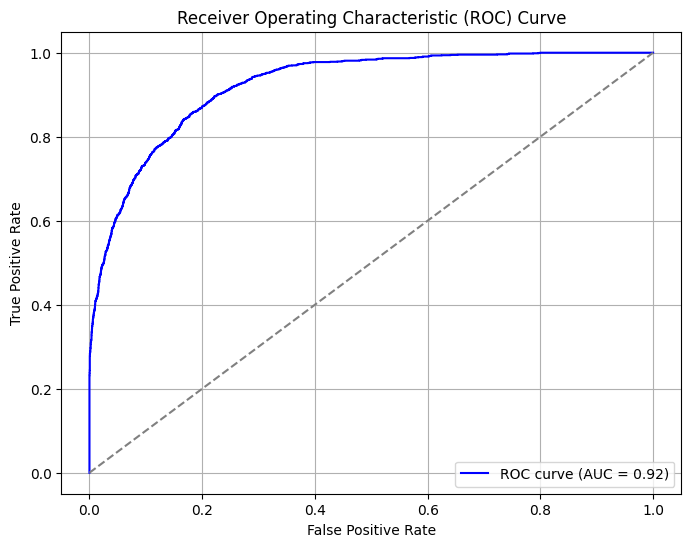

In [17]:
plot_roc_curve(fpr, tpr, roc_auc)

In [18]:
def plot_feature_importance(model, X, max_features=10):
    """
    Plots feature importance for the model, showing the top N features.

    Parameters:
    - model: trained model with a `feature_importances_` attribute (e.g., RandomForest, XGBoost)
    - X: DataFrame or array, features used for training the model (to extract feature names)
    - max_features: int, the number of top features to display (default is 10)
    """
    
    # Extract feature importances (if available)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Get feature names from the DataFrame if it has columns, or generate default names if ndarray
        feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]
        
        # Create DataFrame to sort and plot feature importance
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(max_features)
        
        # Plot top feature importances
        plt.figure(figsize=(8, 6))
        plt.barh(importance_df['Feature'], importance_df['Importance'], color='purple')
        plt.xlabel('Importance')
        plt.title(f'Top {max_features} Feature Importances')
        plt.gca().invert_yaxis()  # Display most important feature at the top
        plt.show()
    else:
        print("No feature importance available for this model.")

In [19]:
plot_feature_importance(best_model, X, max_features=10)

No feature importance available for this model.
